Predict whether a customer will default on a loan based on their financial and demographic data

In [19]:
# import libraries 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, accuracy_score
sns.set()

Load , Read , Transform and Extract Data 

In [4]:
train_df = pd.read_csv("data/Training Data.csv")
train_df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [5]:
# normalise 
train_df.isnull().sum()
train_df

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
251995,251996,8154883,43,13,single,rented,no,Surgeon,Kolkata,West_Bengal,6,11,0
251996,251997,2843572,26,10,single,rented,no,Army_officer,Rewa,Madhya_Pradesh,6,11,0
251997,251998,4522448,46,7,single,rented,no,Design_Engineer,Kalyan-Dombivli,Maharashtra,7,12,0
251998,251999,6507128,45,0,single,rented,no,Graphic_Designer,Pondicherry,Puducherry,0,10,0


In [7]:
train_df['Risk_Flag'].value_counts()
#train_df

0    221004
1     30996
Name: Risk_Flag, dtype: int64

In [8]:
train_df['Risk_Flag'].value_counts(normalize=True)

0    0.877
1    0.123
Name: Risk_Flag, dtype: float64

Numerical variables-
 - We will first examine the relationships between Risk categories and the numeric variables in the dataset using the histplot to see if there are any trends or patterns in the distribution.

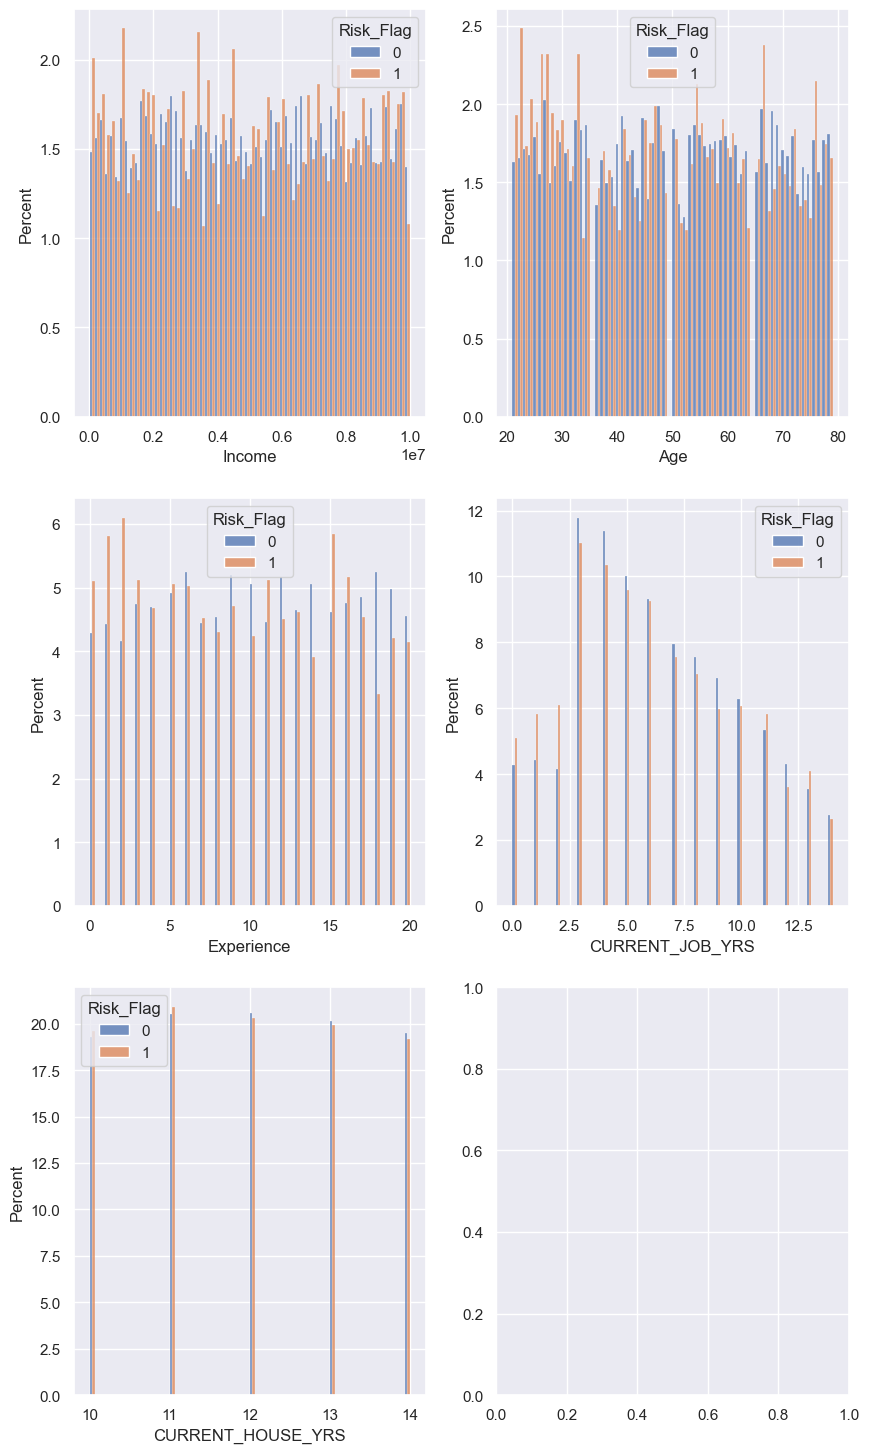

In [10]:
# using a loop to draw multiple kdeplots
fig, axes = plt.subplots(3, 2, figsize=(10, 18))

col1 = ['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']

for col, ax in zip(col1, axes.flat):
    sns.histplot(x=col, data=train_df, hue='Risk_Flag', common_norm=False, stat='percent', multiple='dodge', ax=ax)
plt.show()

There are quite a lot of differences shown.

In terms of income, we see the income of in-default customers peaks a bit earlier and also later than normal customers, meaning that people who make less or more than the income range of normal customers have a higher risk of defaulting.

The age distribution pattern is also very clear, with defaulting customers disproportionately younger than normal customers. This makes a lot of sense, as younger customers, being less established in terms of employment and financial stability, are indeed more prone to not pay their loans on time.

The "Experience" chart is interesting. It shows that people who just joined the workforce tend to default more.

The "Years at Current Job" chart echoes the findings above, showing that more in-default customers than normal customers just started their current job.

The "Number of Years at Current Residence" chart, in contrast, does not show a very clear difference between the 2 customer groups. It suggests that for people who have stayed at their current residence between 10 and 14 years, there is almost a 50-50 chance for them to either default or not default. This might mean that this variable is not very indicative of one's potential to default.

Categorical Variables
- Now that we have examined the numeric variables, we will use countplots to explore the relationships between risk categories and categorical variables.

1. Marriage Status vs Default Risk

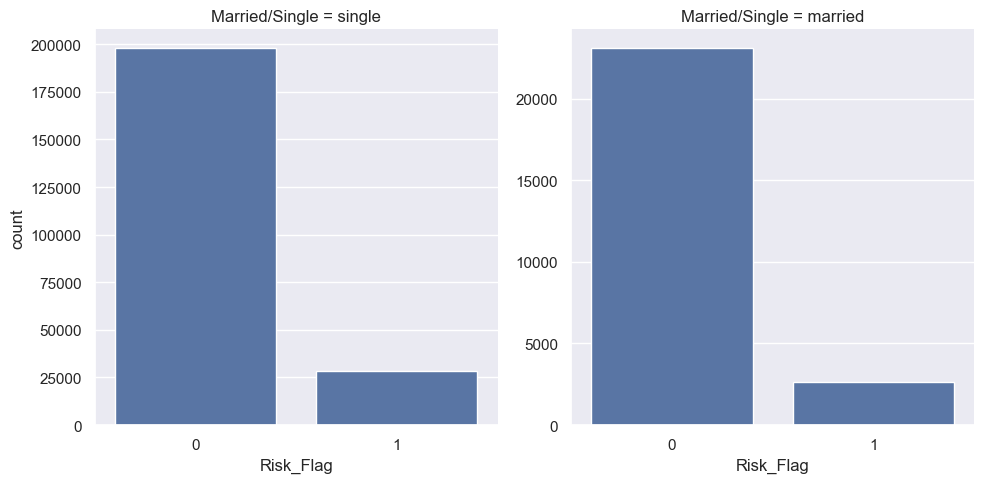

In [11]:
sns.catplot(x='Risk_Flag', data=train_df, col='Married/Single', kind='count', sharey=False)
plt.show()

By setting the share y axis option off, we are able to compare the percentage distribution of the 2 plots. We can see the the share of married people as in-default customers are slightly less than that of the single people.

2. House Ownership vs Default Risk

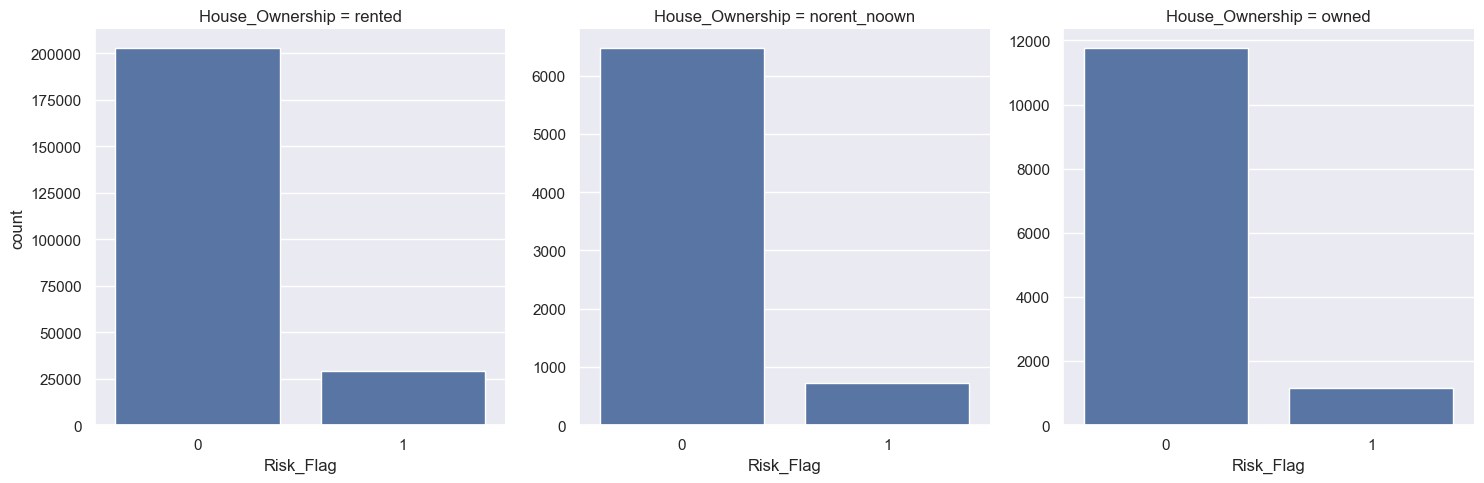

In [12]:
sns.catplot(x='Risk_Flag', data=train_df, col='House_Ownership', kind = 'count', sharey=False)
plt.show()

We can see from the charts above that renters have the highest risk of defaulting while people that own properties are less likely to default.

3. Profession and State vs Default Risk

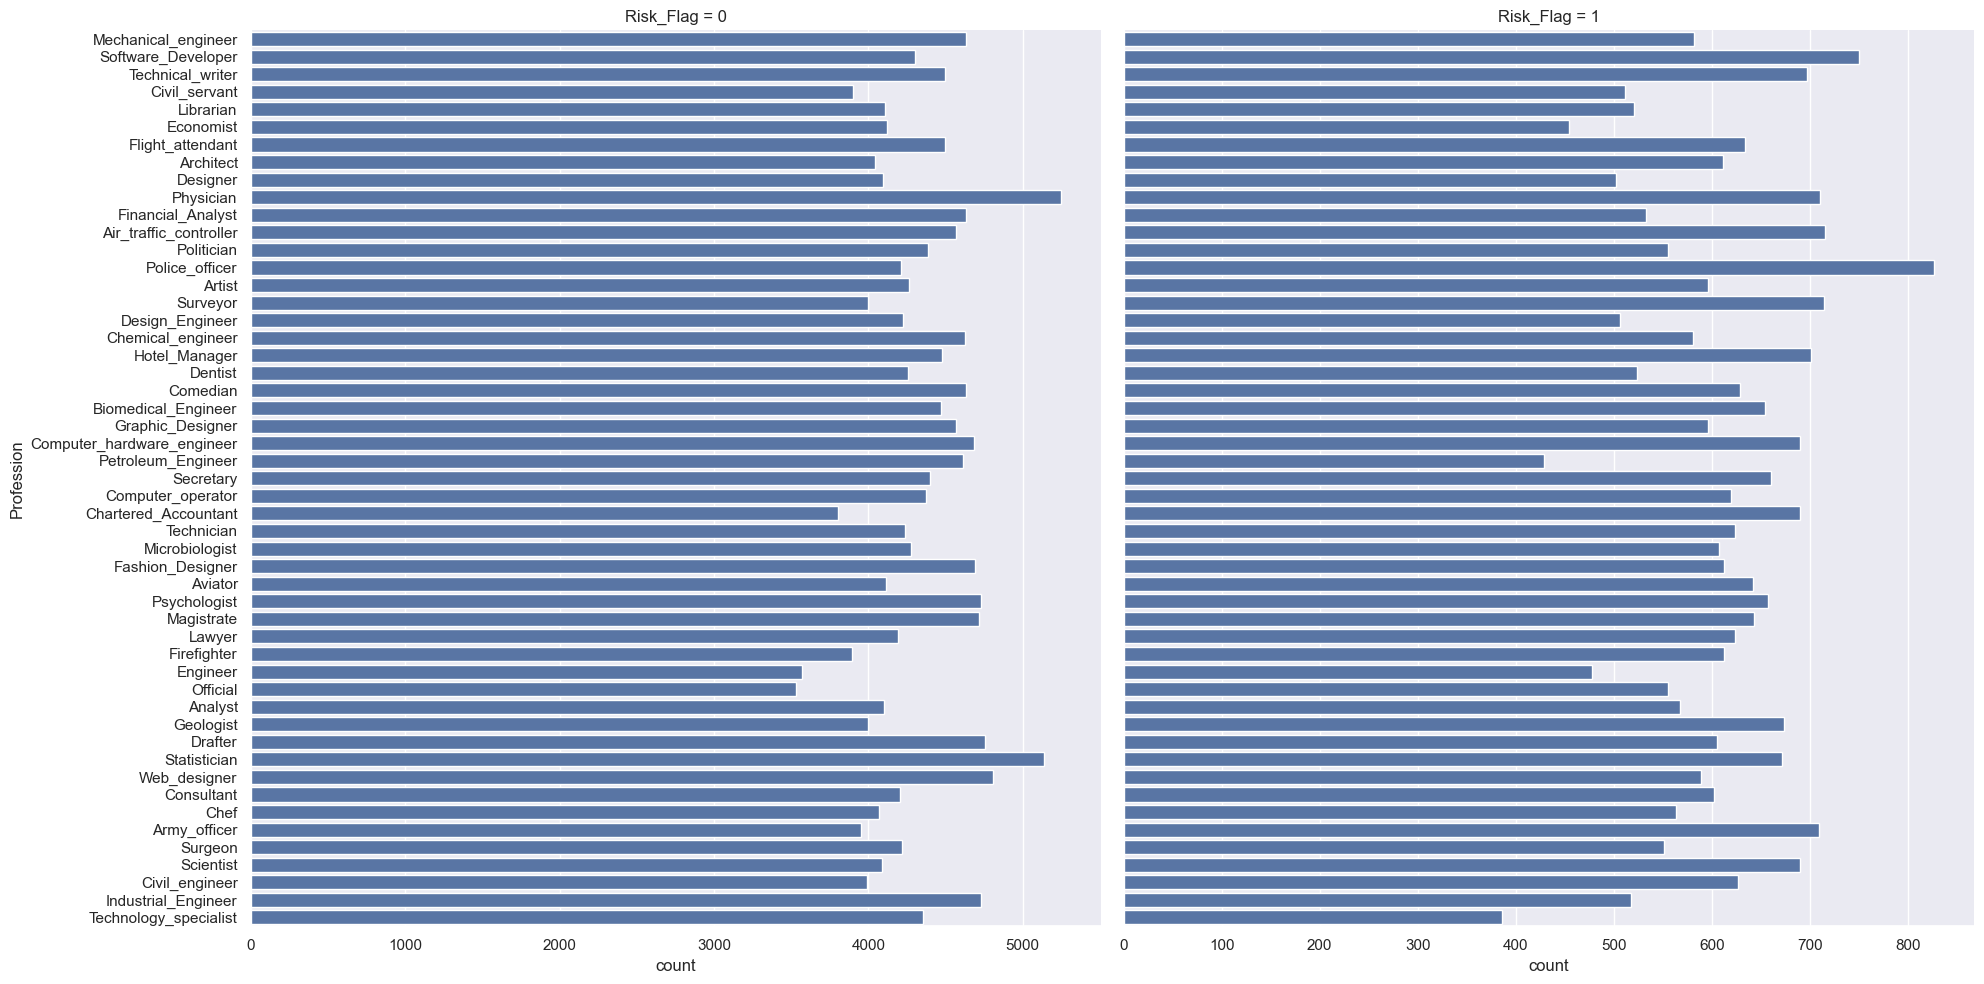

In [14]:
sns.catplot(y='Profession', data=train_df, col='Risk_Flag', kind='count', sharex=False, height=10)
plt.show()

Professional and their areas relation

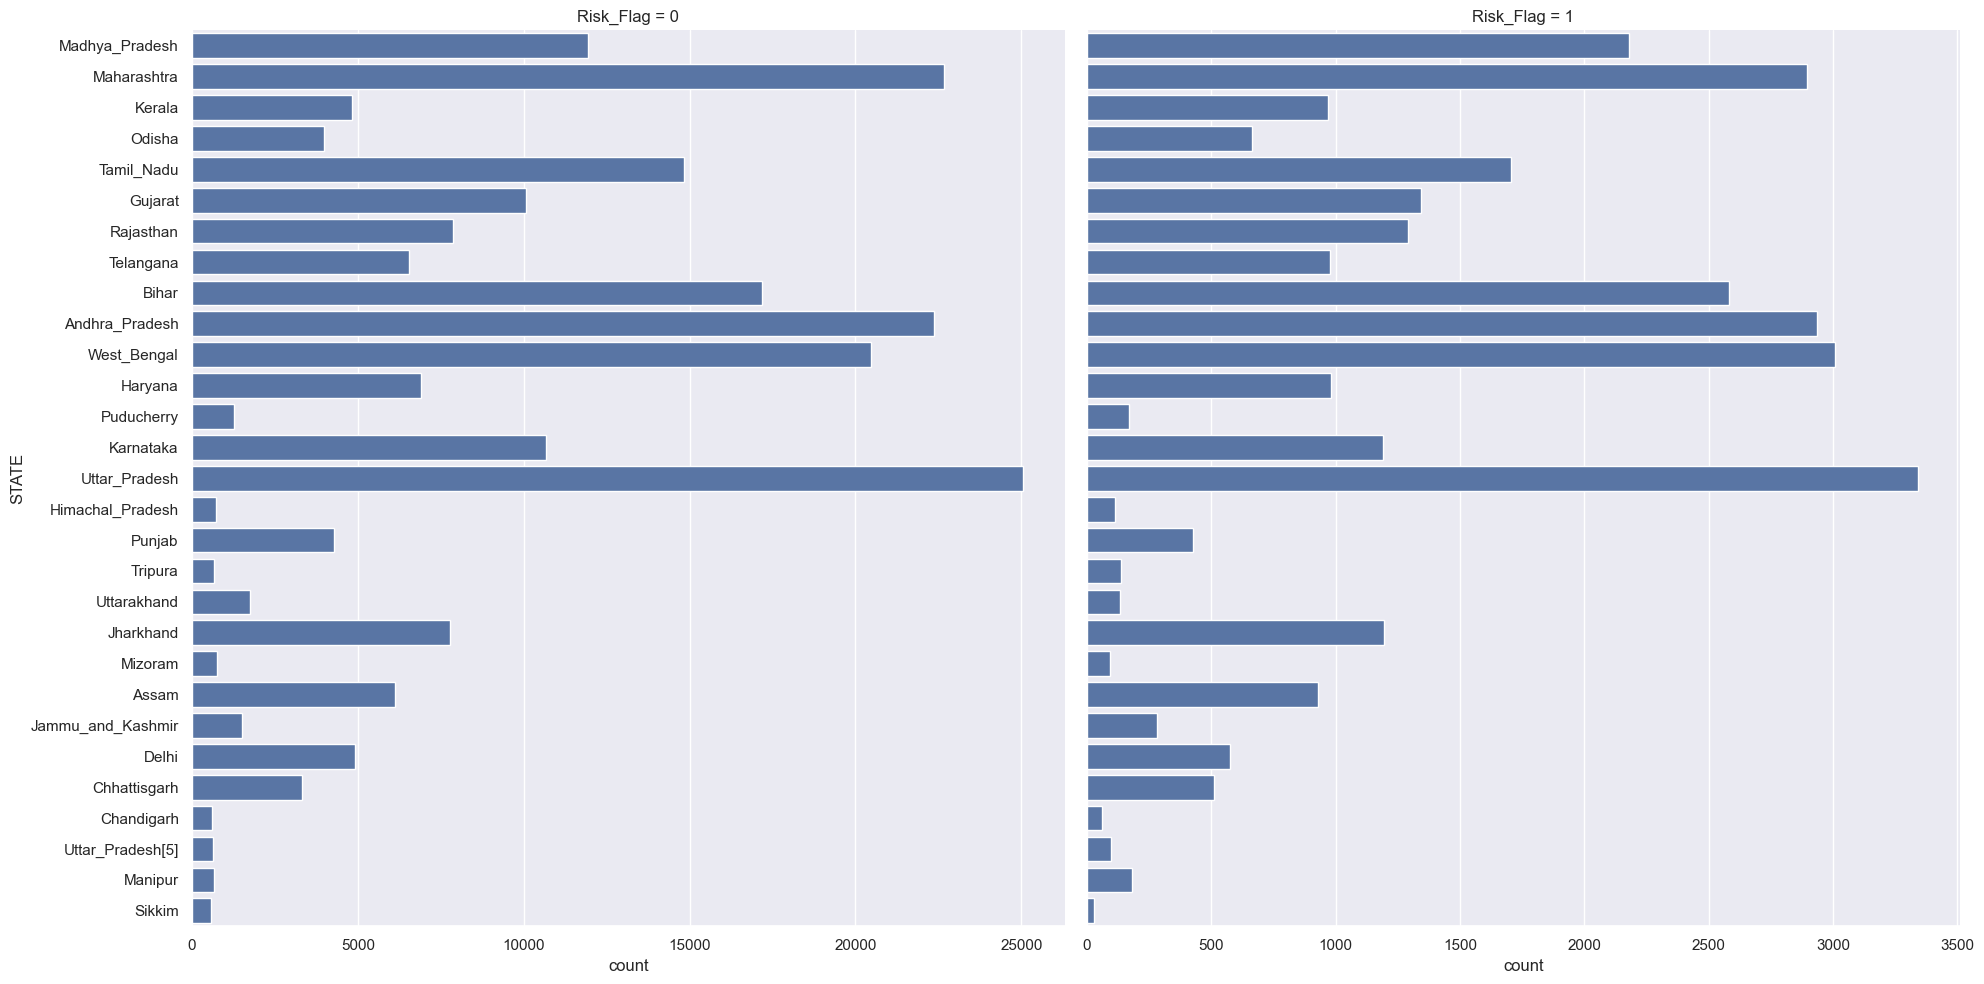

In [16]:
sns.catplot(y='STATE', data=train_df, col='Risk_Flag', kind='count', sharex=False, height=10)
plt.show()

We can see from the 2 countplots above that the job/profession and state distribution do differ to a varying extent between normal and in-default clients. These 2 categoric variables could be indicative of one's tendency to default.

Default Risk Prediction
- Now that we have examine these different variables individually, we will try to set up predicitve models to see how well they can perform on the training data and use them to classify our test dataset. In this article, we will explore both Logistic Regression and Random Forest as our modeling methods.

1. Logistic Regression

In [17]:
# Tranform non numeric variables into binary 
train_df1 = pd.get_dummies(train_df,drop_first=True)
# model logistic regreassion
y = train_df1['Risk_Flag'].values
X = train_df1.drop(['Risk_Flag'], axis=1).values

# using SMOTE to resample the dataset to correct its class imbalance
smote = SMOTE()
X,y =smote.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0, stratify=y)
logreg=LogisticRegression()
logreg.fit(X_train, y_train)
pred=logreg.predict(X_test)

# print out the classification report
print('Classification Reports: \n', classification_report(y_test, pred))
conf_mat = confusion_matrix(y_true=y_test, y_pred=pred)
print('Confusion Matrix: \n', conf_mat)

Classification Reports: 
               precision    recall  f1-score   support

           0       0.54      0.59      0.57     66302
           1       0.55      0.50      0.52     66301

    accuracy                           0.55    132603
   macro avg       0.55      0.55      0.55    132603
weighted avg       0.55      0.55      0.55    132603

Confusion Matrix: 
 [[39375 26927]
 [33192 33109]]


In [18]:
print('Percentage of default customers in the test dataset:', round(np.mean(y_test),2) * 100, '%')

Percentage of default customers in the test dataset: 50.0 %


The results are pretty disappointing. After SMOTE resampling, the share of default and non-default customers should be around 50-50. The Logistic Regression model above only has an accuracy of 51%, which means it is barely more accurate than just randomly classifying each customer. There are also a lot of false positives to make this model useful.

**2. Random Forest**
- We then use the random forest algorithm coupled with Grid Search to see which hyperparameter settings are better. We use the f1 score as the score for picking the best setting because we want a nice balance between low false positives and low false negatives.

In [20]:
param_grid = {'max_depth':[4, 8]}
model = RandomForestClassifier(random_state=0)
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
CV_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [4, 8]}, scoring='f1')

In [22]:
# Summarise the results
best_score, best_params = CV_model.best_score_, CV_model.best_params_
print("Best: %f using %s" % (best_score, best_params))

# Extract the est model and evaluate it in the test set
best_model = CV_model.best_estimator_
pred1=best_model.predict(X_test)

print('Classification report: \n', classification_report(y_test, pred1))
conf_mat = confusion_matrix(y_true = y_test, y_pred=pred1)
print('Confussion matrix: \n', conf_mat)

np.mean(y_test)

Best: 0.749940 using {'max_depth': 8}
Classification report: 
               precision    recall  f1-score   support

           0       0.75      0.75      0.75     66302
           1       0.75      0.75      0.75     66301

    accuracy                           0.75    132603
   macro avg       0.75      0.75      0.75    132603
weighted avg       0.75      0.75      0.75    132603

Confussion matrix: 
 [[49515 16787]
 [16336 49965]]


0.49999622934624405

This model is indeed significantly better than Logistic Regression. The accuracy and precision is around 75% which is way better than randomly classifying the dataset and the recall rate is also pretty good, meaning that we get to catch more potentially risky customers. With this model set up, we can now use it on the test dataset to generate our final classification recommendations.

In [25]:
# test
test_df = pd.read_csv('data/Test Data.csv')
X = pd.get_dummies(test_df, drop_first=True).values
y = best_model.predict(X)

y = pd.Series(y)
prediction = pd.concat([test_df['ID'], y], axis=1).set_index('ID')
prediction

,0
ID,
1,0
2,0
3,0
4,0
5,0
...,...
27996,1
27997,0
27998,0


In [28]:
print('Percentage of potentially risky customers in the tst dataset', round(np.mean(y), 2) * 100, '%')

Percentage of potentially risky customers in the tst dataset 25.0 %
